# Goal of Analysis

The **goal of my project** is to create a restaurant recommender system that uses a dataset of predicted ratings for restaurants yet visited by respective reviewers to populate suggestions based on category (i.e. restaurant type) and rating tolerance inputs of the user.

Though my initial goal for this project was to perform a sentiment analysis on User-review textual data and, through the use of content filtering, build a restaurant recommender system; its final iteration is now shifting to a Model-based Collaborative Filtering Approach in leveraging a dataset of known ratings to create that of the unknown ones. 

There are two main reasons behind this change in analysis goal:
- While a content-based system would work to assess similarity between restaurants based on reviews data, it would not be too great in recommending a **variety** of different restaurants. A desired use of the model is to help the user discover **new** restaurants to them.
- In opting for a Collaborative-based approach, I had two main techniques to choose from: memory or model based approaches. The following points helped me opt for the model based approach:
    - Because I am going to be working with sizeable data, a Utility (sparse) Matrix of unique reviewers' scores for all restaurants would most likely struggle on distant reliant algorithms. A major reason for this is the inherent sparsity in the utility matrix, meaning not every user in my dataset would have rated every restaurant.
    - Secondly, the models would help make this approach a more scalable one as it works to reduce dimensionality of the Utility Matrix.


In my model-based approach, I will opt to use a Matrix Factorization based algorithm. Matrix Factorization models look to leverage hidden factors, called latent variables or embeddings, of both users and items that may impact a rating value in question. Examples of embeddings in the context of restaurant reviews can be: "Was the restaurant part of a chain?" "Did the reviewer go at a time of the day where the restaurant was at its busiest?" etc.
        - **However**, one drawback of the hidden (latent) variables is that we lose the ability to infer on what exactly they represent.


The algorithm I will use is the Funk Singular Value Decomposition (**FunkSVD**), as it treats the problem of learning the latent variables to best make rating predictions as an optimization problem.


The motivation behind this recommendation model derives from my love of food, and wanting to build a tool to help one discover and support growing restaurants.

------

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [13]:
import matplotlib

## Yelp JSON files Parsing

Because the relevant datasets obtained from the Yelp Open Dataset [resource page](https://www.yelp.com/dataset) are sizable, in the GigaBytes, I leveraged the command line tool `jq` to help in my parsing of the JSON files. Documentation on the `jq` command line tool can be found [here](https://stedolan.github.io/jq/).

Though the Yelp Dataset contains a `Users` file containing information about the users and their activity on the platform, for the purposes of this analysis I will only use the Businesses (Restaurants) and Reviews files.

### Parsing the `Business` JSON file
After an initial import of the complete `business` JSON file, and a brief analysis on available information in it shown below, I made the decision to parse the file into one that would only contain information on Phoenix,AZ restaurants that met the following constraints:
- Are Phoenix,AZ based
- Have a `review_count` column value of 75 or less
- Are considered as "open" with the `is_open` column equating to `1` (binary)
- The `categories` column does not include "Fast Food" restaurants, and is not fully `null`

In [14]:
bus_df = pd.read_json(path_or_buf='/Users/cesarsmacpro/Desktop/YelpData/yelp_academic_dataset_business.json', lines=True)
print(f'The shape of the bus_df dataset is: {bus_df.shape}.')
#showing the first 5 rows of the dataset
bus_df.head()

The shape of the bus_df dataset is: (209393, 14).


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


In [15]:
bus_df['state'].value_counts().head(10)

AZ    60803
NV    39084
ON    36627
OH    16392
NC    16218
PA    12376
QC    10233
AB     8682
WI     5525
IL     2034
Name: state, dtype: int64

Above we can see the distribution of State frequencies in the Yelp Business dataset. Understanding that we're limited to the information available in it, I will opt to focus on restaurants **based in Arizona**, as it is the state with the most available business data.

In [16]:
# creating a DataFrame of AZ based businesses only
bulp = bus_df[bus_df['state']=='AZ']

# getting a look at the top 5 cities with associated businesses in the state of Arizona
bulp['city'].value_counts().head(5)

Phoenix       20170
Scottsdale     9341
Mesa           6577
Tempe          4797
Chandler       4579
Name: city, dtype: int64

More specifically, we have the most amount of businesses in Phoenix, Arizona as shown above.

In [17]:
# Getting a look into the datatype for the columns in the bus_df DataFrame
bus_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209393 entries, 0 to 209392
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   209393 non-null  object 
 1   name          209393 non-null  object 
 2   address       209393 non-null  object 
 3   city          209393 non-null  object 
 4   state         209393 non-null  object 
 5   postal_code   209393 non-null  object 
 6   latitude      209393 non-null  float64
 7   longitude     209393 non-null  float64
 8   stars         209393 non-null  float64
 9   review_count  209393 non-null  int64  
 10  is_open       209393 non-null  int64  
 11  attributes    180348 non-null  object 
 12  categories    208869 non-null  object 
 13  hours         164550 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 22.4+ MB


The datatypes of the columns look to be okay for now, but I may later consider updating columns like the `review_count` and `is_open` ones to an `int32` datatype for efficiency purposes.

In [18]:
# Getting the brief summary statistics on the numerical features of bus_df 
bus_df.describe()

,latitude,longitude,stars,review_count,is_open
count,209393.000000,209393.000000,209393.000000,209393.000000,209393.000000
mean,38.579934,-97.390217,3.538055,36.937505,0.806632
std,4.940448,16.718535,1.023543,123.343597,0.394940
min,21.497258,-158.025525,1.000000,3.000000,0.000000
25%,33.638658,-112.269476,3.000000,4.000000,1.000000
50%,36.147408,-111.743531,3.500000,9.000000,1.000000
75%,43.611693,-79.972679,4.500000,27.000000,1.000000
max,51.299943,-72.806550,5.000000,10129.000000,1.000000


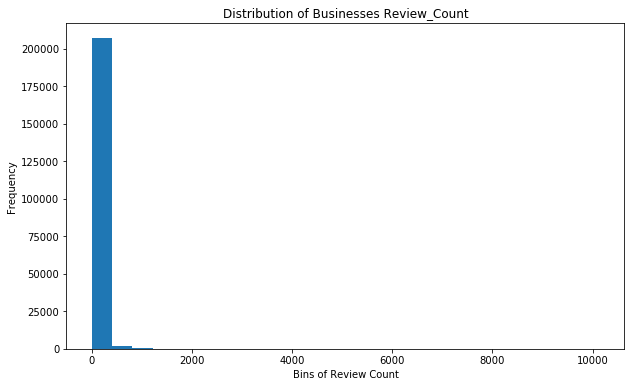

In [19]:
plt.figure(figsize=(10,6))
bus_df['review_count'].hist(bins = 25)
plt.title('Distribution of Businesses Review_Count')
plt.xlabel('Bins of Review Count')
plt.ylabel('Frequency')
plt.grid(None)
plt.show()

After this initial look into the available businesses data, I elected the constraints to parse the file as mentioned earlier, but opted to do so via the command line with the help of `jq` for efficiency purposes. The code used was as follows to create a parsed restaurant JSON file named `finrestphx.json`:
- `cat yelp_academic_dataset_business.json | jq -n '[inputs]' | jq .'[] | select(.categories != null) | select(.categories | contains("Restaurant")) | select(.city=="Phoenix" and .state=="AZ") | select(.categories | contains("Fast Food") | not) | select(.review_count<=75) | select(.is_open==1)' | jq -n '[inputs]' | jq -c '.[]' > finrestphx.json`

In [20]:
# import the finrestphx.json file, containing 1,034 restaurants
# later i will expose the inaccuracy of the original review_count column after my sub-review file import and merge
# And perform the second trim of the data on review_count <= 40

In [21]:
# Reading in the "finrestphx.json" file
rest_df = pd.read_json(path_or_buf='/Users/cesarsmacpro/Desktop/YelpData/finrestphx.json', lines=True)
print(f'The shape of the bus_df dataset is: {rest_df.shape}.')
#showing the first 5 rows of the dataset
rest_df.head()

The shape of the bus_df dataset is: (1034, 14).


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,a_E-rLe2zcyX-X4FKhWWRg,Tacos y Mariscos Sinaloa,2808 W Mcdowell Rd,Phoenix,AZ,85009,33.466146,-112.119726,3.0,14,1,"{'RestaurantsTakeOut': 'True', 'GoodForKids': ...","Restaurants, Mexican","{'Monday': '9:0-23:0', 'Tuesday': '9:0-23:0', ..."
1,xOcJHzV3X0lKHN9LcBpvqw,Catabella's Deli &Cafè,"1990 W Camelback Rd, Ste 105",Phoenix,AZ,85015,33.510246,-112.101456,5.0,3,1,"{'BusinessParking': '{'garage': False, 'street...","Restaurants, Delis, Cafes",None
2,c7JoAt6a3Ufkpn3TrGU23A,Santanas Mexican Food,1930 W Buckeye Rd,Phoenix,AZ,85009,33.436984,-112.101267,3.0,6,1,"{'RestaurantsGoodForGroups': 'True', 'Ambience...","Mexican, Restaurants",None
3,AVsZE_gMkuBmRLRiqmPqJQ,City Cafe,411 N Central Ave,Phoenix,AZ,85004,33.452853,-112.073544,3.5,3,1,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Restaurants, Coffee & Tea, Cafes, Food","{'Monday': '7:0-17:0', 'Tuesday': '7:0-17:0', ..."
4,vAf3U749Y1hnFfnMpKHuyw,OUTLAWS Bar & Restaurant,6705 E Cavecreek Rd,Phoenix,AZ,85331,33.832225,-111.935356,2.5,22,1,"{'RestaurantsGoodForGroups': 'True', 'Business...","Restaurants, Barbeque","{'Tuesday': '12:0-2:0', 'Wednesday': '12:0-2:0..."


### Parsing the `Reviews` JSON file
My initial approach in parsing the reviews JSON file (~6.3GB) centered around using a list of unique `business_id`'s from the `finrestphx.json` and use the values to filter the review file via a jq query. However, after numerous iterations of an attempt at using the referenced output as input to filter the review file, I came to the conclusion that **splitting** the large review file into subfiles was a feasible approach.

I used the following terminal command to split the review file into 11 sub-files:
- `split -l 800000 yelp_academic_dataset_review.json`

Below I will work to first import the 11 sub-review files, merge each sub-file with the `rest_df` DataFrame obtain the reviews respective to the 1,034 different restaurants per review subset; and lastly concatenate the result.

In [22]:
# Importing the 11 sub-files via a for looop (started at 1:24pm)
for num in range(1,12):
    exec(f'subrev_df{num} = pd.read_json(path_or_buf="/Users/cesarsmacpro/Desktop/YelpData/yelp_reviews_sub{num}.json", lines=True)')

Checking the shape and DataFrame of a couple of the sub-review DataFrames:

In [23]:
print(f'The shape of sub-review DataFrame 3: {subrev_df3.shape}.')
print('\n')
print('The DataFrame below is for sub-rev 7:')
subrev_df7.head(5)

The shape of sub-review DataFrame 3: (800000, 9).


The DataFrame below is for sub-rev 7:


,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,3tDsvGXjJy10rq1DwELLHQ,FTJq8peHvoa2tsTF1YI2hQ,tshN5rYRrzanHu4ZiwCVrA,1,1,0,1,"I was craving some Soup, Salad and Breadsticks...",2016-08-28 14:10:07
1,9PJWBZAOsd1TVxG6MtUTDw,FYmGxLIB68Z6wxwnqRohXg,8oSlQByXcv-QXcBPD8UfNw,1,0,0,0,No coffee at 8am. Unfreakin believable! Was at...,2019-11-17 15:23:25
2,9ArP5oFoMTr7V-7K63YHDg,CLfqC-AQJLkmOHV3d-KCZg,4aQrdft2iZDvzeXzDrWhew,3,21,15,21,WeekDAY 4 stars - still too crowded though.\n\...,2019-10-10 02:18:43
3,CmEgxDnorB_MkCWCPScw4w,3w_M4Bxvpp_owMSgI_TdWQ,yqcZE1jlo5W-h-lVm4le1w,5,0,0,0,"In Las Vegas, this is probably the best pho pl...",2019-11-03 21:54:48
4,jZ4YkVjxqPDZ2iXLAaU7JQ,yyDp7MZ2st7p0fOQuFYpcA,JeWEJGxDyg75l_810bqP7Q,5,2,0,1,Finally stopped by to check out this store and...,2017-05-27 19:08:24


Merging each sub-review file with the `rest_df` DataFrame, and creating a final dataset by concatenating the results containing the reviews respective to the restaurants.

In [24]:
# Ran at 1:58pm, finished at 1:59pm
subrev_df_dict = {'subrev_df1':subrev_df1,'subrev_df2':subrev_df2, 'subrev_df3':subrev_df3, \
                  'subrev_df4':subrev_df4, 'subrev_df5':subrev_df5, 'subrev_df6':subrev_df6, \
                  'subrev_df7':subrev_df7, 'subrev_df8':subrev_df8, 'subrev_df9':subrev_df9, \
                  'subrev_df10':subrev_df10, 'subrev_df11':subrev_df11}

rest_subrev_df_list = []

for key, val in subrev_df_dict.items():
    #inner merge/join, so the reviews will be unique to its respective business; no duplicates of a review instance
    exec(f'rest_{key} = {key}.merge(rest_df, on="business_id", suffixes=("_lft", "_rgt"))')
    exec(f'rest_subrev_df_list.append(rest_{key})')

# the final dataset made via concaetantion
rest_revdf = pd.concat(rest_subrev_df_list)

I will now look to confirm that the number of records in the final restaurant+review DataFrame has the number of expected reviews, by comparing its results to the total sum of `rest_df`'s `review_count` column.

In [25]:
tot_revs = rest_df['review_count'].sum()

print(f'The total number of expected reviews from the Phoenix restaurant DataFrame (rest_df) is: {tot_revs}.')
print(f'The total number of records (reviews) in my final restaurant+review (rest_revdf) DataFrame is: {rest_revdf.shape[0]}.')

The total number of expected reviews from the Phoenix restaurant DataFrame (rest_df) is: 27992.
The total number of records (reviews) in my final restaurant+review (rest_revdf) DataFrame is: 28862.


In [26]:
# resetting the index on the restaurant+review DataFrame
rest_revdf.reset_index(drop=True, inplace=True)
rest_revdf

,review_id,user_id,business_id,stars_lft,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_rgt,review_count,is_open,attributes,categories,hours
0,JduSoCM6fn6a8EpfZoL4pg,4bxhIKz9ePWqD93UkEjnbg,NAigH4SqnuuQip8lekq7GQ,5,3,2,4,Another great Port of Subs experience! The XL ...,2017-01-27 21:39:23,Port of Subs,...,AZ,85027,33.683180,-112.098636,3.5,55,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
1,TJtAtX9wXYQP8TYghiOCew,XEHZoTDWjw3w-gcQyYIe4g,NAigH4SqnuuQip8lekq7GQ,3,0,1,0,I am not a huge sub fan to start with....\n\nT...,2009-05-27 20:12:59,Port of Subs,...,AZ,85027,33.683180,-112.098636,3.5,55,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
2,mBuXcM08Tl57efVTfakIug,IC7NLIeWhS45_aEE_8aVUg,NAigH4SqnuuQip8lekq7GQ,5,1,0,0,The guy who helped me made very generous sandw...,2016-01-19 16:10:03,Port of Subs,...,AZ,85027,33.683180,-112.098636,3.5,55,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
3,fK-GXrlnAzWJt6S-R8lTFQ,1zj0n7gyJ0jmWfYQRhvstA,NAigH4SqnuuQip8lekq7GQ,5,0,0,0,Mmmmmmmmm one of my favorite sandwich location...,2014-07-16 15:56:18,Port of Subs,...,AZ,85027,33.683180,-112.098636,3.5,55,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
4,B_Y-Qo5xkW19WdkPsbxImw,T6Gti8sicxZZ28fuS1JFKA,NAigH4SqnuuQip8lekq7GQ,1,0,0,0,I'm not a meat person but they put almost NO m...,2013-02-04 05:31:28,Port of Subs,...,AZ,85027,33.683180,-112.098636,3.5,55,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28857,2xPdQZ0ojl7KtlzuzwkcFg,DPitNu466172os6m0Yri1Q,nUYFVybkp6HqY4wf8sNy5A,1,0,10,0,Came in on a Sunday. Place was jam packed. Tub...,2019-07-14 21:50:29,La Botana,...,AZ,85031,33.497482,-112.152895,4.0,37,1,"{'Alcohol': 'u'beer_and_wine'', 'DogsAllowed':...","Restaurants, Mexican, Tacos, Seafood","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
28858,3N5wxeBFAvpBwRA8sSix_A,ZRDh_86bbknHNGsmXNi2gA,EVIgcyBM4QQGi_zQ8W-Zgg,4,1,1,1,"I got three tacos (deep fried fish, grilled ch...",2019-12-01 01:30:33,Senor Taco Express,...,AZ,85018,33.479726,-111.982986,4.5,6,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Mexican, Restaurants","{'Monday': '8:0-17:0', 'Tuesday': '8:0-22:0', ..."
28859,r2LLBmatI5kh1eSppNB2ng,KrAiU8OyuQlXglpAEgYeBg,EVIgcyBM4QQGi_zQ8W-Zgg,5,1,0,0,Best bean and cheese burrito around and I am a...,2019-11-11 01:19:15,Senor Taco Express,...,AZ,85018,33.479726,-111.982986,4.5,6,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Mexican, Restaurants","{'Monday': '8:0-17:0', 'Tuesday': '8:0-22:0', ..."
28860,rr7AlDqINphOitshZPykZg,5Fw6Qlj2x6fOiooZEnedmA,npFreYuGvPtNbHo0x74zcA,5,0,1,0,My family and I used to live nearby and we use...,2016-02-27 15:22:28,The Adobe Restaurant,...,AZ,85016,33.520966,-112.023914,3.0,36,1,"{'BusinessAcceptsCreditCards': 'True', 'Ambien...","Active Life, Golf, American (Traditional), Res...","{'Monday': '6:0-19:0', 'Tuesday': '6:0-19:0', ..."


The number of records in the concatenated `rest_revdf` DataFrame surpasses the expected value (27,992). Because there is a surplus in expected reviews, I will look to get an accurate count of distinct reviews per restaurant below. This will be done via a `value_counts()` function. 

However, I will update the `review_count` column with the accurate amount of distinct reviews by applying the `transform` function to a restaurant groupby's results.

In [27]:
# Important to note, businesses from the final joined DF should NOT have more than 75 reviews per our jq code
rest_revdf['business_id'].value_counts()

da_QOspls2XoU5AZ6QNcww    82
dQ8kST_dfWcZVcLlIk7yRA    80
sm_GANEfgouoVPsNKXNzDA    79
TT9u-iVu9mtq7tdCTJWwnw    78
fg69aogbeD-GKjmr_4cN4w    78
                          ..
vv--IXro46OuHpYua5XYHw     3
rUgLG2CzPi26e6cMUjk4kA     3
bp1poPeNYeT0tdT2RdwZ7A     3
RvrHLdR_4-iYcDY0_xsFIQ     3
47wfOfbWXdaxSCRPWBh8fQ     3
Name: business_id, Length: 1034, dtype: int64

In [28]:
# Getting an accurate count of reviews per restaurant (index)
rest_revdf.groupby(['business_id'])['review_id'].transform('count')

0        60
1        60
2        60
3        60
4        60
         ..
28857    38
28858     6
28859     6
28860    39
28861    59
Name: review_id, Length: 28862, dtype: int64

In [29]:
# Overriding the 'review_count' column with the accurate review counts
rest_revdf['review_count'] = rest_revdf.groupby(['business_id'])['review_id'].transform('count')

Confirming the update in accurate reviews per restaurant by using business `'fg69aogbeD-GKjmr_4cN4w'` to confirm it is equal to 78.

In [30]:
rest_revdf[rest_revdf['business_id'] == 'fg69aogbeD-GKjmr_4cN4w'].head(1)

,review_id,user_id,business_id,stars_lft,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,stars_rgt,review_count,is_open,attributes,categories,hours
5768,qRR5QBPKhN937rdCt59Mxw,jVDpeJNJfORtA4-Wb5NSeQ,fg69aogbeD-GKjmr_4cN4w,5,0,0,0,The food is delicious and healthy. They have a...,2017-06-06 22:38:11,Eat By Stacey Weber,...,AZ,85028,33.58318,-111.978611,4.5,78,1,"{'OutdoorSeating': 'True', 'WiFi': 'u'free'', ...","Organic Stores, Restaurants, Vegetarian, Vegan...","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'..."


In [31]:
rest_revdf['business_id'].value_counts().sum() == rest_revdf.shape[0]

True

It looks good.

----

### EDA, Filtering, and Cleaning the `rest_revdf` DataFrame

Below I will go through the following steps involving exploratory data analysis, filtering, and cleaning of the dataset:
- Checking for duplicate data or columns on the final `rest_revdf` DataFrame, and updating datatypes or feature names as need be.
- Now that the dataset contains an accurate `review_count` for a respective restaurant, there were a few of them now with a value for the column greater than the original `jq` script filtered for (75 or less). I will need to make a decision on the final threshold once again.
- Explore if there may be any missing pieces of information across the dataset features.
    - And if so, decide if an imputation method may be needed, or the feature in question itself.

After applying these steps, I will have my final dataset to begin the modeling.

In [32]:
# Looking at features and their datatype
rest_revdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28862 entries, 0 to 28861
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   review_id     28862 non-null  object        
 1   user_id       28862 non-null  object        
 2   business_id   28862 non-null  object        
 3   stars_lft     28862 non-null  int64         
 4   useful        28862 non-null  int64         
 5   funny         28862 non-null  int64         
 6   cool          28862 non-null  int64         
 7   text          28862 non-null  object        
 8   date          28862 non-null  datetime64[ns]
 9   name          28862 non-null  object        
 10  address       28862 non-null  object        
 11  city          28862 non-null  object        
 12  state         28862 non-null  object        
 13  postal_code   28862 non-null  object        
 14  latitude      28862 non-null  float64       
 15  longitude     28862 non-null  float6

From the results above, and looking at the `rest_rvdf` dataset a few cells prior, the following updates to the features will be made:
- Update in name:
    - `stars_lft` -> `review_stars` (feature derives from the review JSON file)
    - `name` -> `rest_name` (restaurant name)
    - `stars_rgt` -> `rest_avg_stars` (average restaurant rating)
    - `review_count` -> `total_reviews`

In [33]:
rest_revdf.rename({'stars_lft': 'review_stars', 'name': 'rest_name', 'stars_rgt': 'rest_avg_stars', \
                   'review_count': 'total_reviews'}, axis=1, inplace=True)

In [34]:
rest_revdf.head(3)

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,rest_name,...,state,postal_code,latitude,longitude,rest_avg_stars,total_reviews,is_open,attributes,categories,hours
0,JduSoCM6fn6a8EpfZoL4pg,4bxhIKz9ePWqD93UkEjnbg,NAigH4SqnuuQip8lekq7GQ,5,3,2,4,Another great Port of Subs experience! The XL ...,2017-01-27 21:39:23,Port of Subs,...,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
1,TJtAtX9wXYQP8TYghiOCew,XEHZoTDWjw3w-gcQyYIe4g,NAigH4SqnuuQip8lekq7GQ,3,0,1,0,I am not a huge sub fan to start with....\n\nT...,2009-05-27 20:12:59,Port of Subs,...,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
2,mBuXcM08Tl57efVTfakIug,IC7NLIeWhS45_aEE_8aVUg,NAigH4SqnuuQip8lekq7GQ,5,1,0,0,The guy who helped me made very generous sandw...,2016-01-19 16:10:03,Port of Subs,...,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."


The following columns will be updated to have a datatype of `int32` for memory efficiency: `review_stars`, `total_reviews`, `is_open`. Though the `review_count` column is continuous, the max value of an column with `int32` datatype is passed the million mark, so more than enough space for practicality.

In [35]:
conv_dict = {'review_stars': 'int32', 'total_reviews': 'int32', 'is_open': 'int32'}
rest_revdf = rest_revdf.astype(conv_dict)

In [36]:
rest_revdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28862 entries, 0 to 28861
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   review_id       28862 non-null  object        
 1   user_id         28862 non-null  object        
 2   business_id     28862 non-null  object        
 3   review_stars    28862 non-null  int32         
 4   useful          28862 non-null  int64         
 5   funny           28862 non-null  int64         
 6   cool            28862 non-null  int64         
 7   text            28862 non-null  object        
 8   date            28862 non-null  datetime64[ns]
 9   rest_name       28862 non-null  object        
 10  address         28862 non-null  object        
 11  city            28862 non-null  object        
 12  state           28862 non-null  object        
 13  postal_code     28862 non-null  object        
 14  latitude        28862 non-null  float64       
 15  lo

With respect to unneeded columns for the purpose of my analysis, the `useful`, `funny`, `cool` columns fall into this assessment as they contain ratings other Yelp users left on the review for a restaurant in question.

Though it these columns may contain useful information for future analysis, I will not include them for efforts in making predictions on something like an expected user rating for a similar restaurant the individual may not have gone to yet.

In [37]:
# Dropping the unneeded columns
rest_revdf.drop(columns=['useful', 'funny', 'cool'], inplace=True)
rest_revdf.head(3)

,review_id,user_id,business_id,review_stars,text,date,rest_name,address,city,state,postal_code,latitude,longitude,rest_avg_stars,total_reviews,is_open,attributes,categories,hours
0,JduSoCM6fn6a8EpfZoL4pg,4bxhIKz9ePWqD93UkEjnbg,NAigH4SqnuuQip8lekq7GQ,5,Another great Port of Subs experience! The XL ...,2017-01-27 21:39:23,Port of Subs,1855 W Deer Valley Rd,Phoenix,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
1,TJtAtX9wXYQP8TYghiOCew,XEHZoTDWjw3w-gcQyYIe4g,NAigH4SqnuuQip8lekq7GQ,3,I am not a huge sub fan to start with....\n\nT...,2009-05-27 20:12:59,Port of Subs,1855 W Deer Valley Rd,Phoenix,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
2,mBuXcM08Tl57efVTfakIug,IC7NLIeWhS45_aEE_8aVUg,NAigH4SqnuuQip8lekq7GQ,5,The guy who helped me made very generous sandw...,2016-01-19 16:10:03,Port of Subs,1855 W Deer Valley Rd,Phoenix,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."


Exploring any missing information in the `rest_revdf` dataset.

In [38]:
rest_revdf.isna().mean()

review_id         0.000000
user_id           0.000000
business_id       0.000000
review_stars      0.000000
text              0.000000
date              0.000000
rest_name         0.000000
address           0.000000
city              0.000000
state             0.000000
postal_code       0.000000
latitude          0.000000
longitude         0.000000
rest_avg_stars    0.000000
total_reviews     0.000000
is_open           0.000000
attributes        0.006479
categories        0.000000
hours             0.156954
dtype: float64

In [39]:
# Taking a look at the various 'attribute' column keys found in the dataset. These keys may not be available uniformally among
    # restaurants
pd.json_normalize(rest_revdf['attributes'].apply(lambda x: {} if pd.isna(x) else x)).isna().mean()

RestaurantsTakeOut            0.096043
BusinessParking               0.062851
WiFi                          0.238999
Caters                        0.326138
OutdoorSeating                0.159933
RestaurantsPriceRange2        0.145659
BusinessAcceptsCreditCards    0.068706
BikeParking                   0.244231
GoodForKids                   0.216756
RestaurantsReservations       0.162532
RestaurantsGoodForGroups      0.199051
RestaurantsAttire             0.287679
Alcohol                       0.258125
NoiseLevel                    0.339616
RestaurantsDelivery           0.125598
HasTV                         0.147980
Ambience                      0.137239
RestaurantsTableService       0.636234
GoodForMeal                   0.283383
WheelchairAccessible          0.753829
HappyHour                     0.811517
BestNights                    0.941203
DriveThru                     0.965144
CoatCheck                     0.941272
GoodForDancing                0.960571
Smoking                  

The only features with missing data are the `attributes` and `hours` columns, with the proportion of empty rows for each being about 0.65% and 15.7% respectively.

Though there is not a uniformal set of `attributes` keys among all restaurants as shown in the cell above, which shows a proportion of missing key values among restaurants in the dataset, the proportion of rows with **no** attribute information is fairly nominal; and not immediately impact the focus of the analysis.

However, the `hours` column has a substantial proportion of its rows have missing information (~15.7%). Because this feature contains dictionaries of a restaurant's operating hours, it is not information that is immediately imputable. 

In lieu of the similarity in missing information among both columns, I will opt to fill the empty row values for both columns with empty dictionaries.

In [40]:
rest_revdf['attributes'] = rest_revdf['attributes'].apply(lambda x: {} if pd.isna(x) else x)
rest_revdf['hours'] = rest_revdf['hours'].apply(lambda x: {} if pd.isna(x) else x)

In [41]:
# Checking the proportion of missing data per column once more
rest_revdf.isna().mean()

review_id         0.0
user_id           0.0
business_id       0.0
review_stars      0.0
text              0.0
date              0.0
rest_name         0.0
address           0.0
city              0.0
state             0.0
postal_code       0.0
latitude          0.0
longitude         0.0
rest_avg_stars    0.0
total_reviews     0.0
is_open           0.0
attributes        0.0
categories        0.0
hours             0.0
dtype: float64

Lastly, I will revisit deciding on a final threshold of `total_reviews` I want the restaurants in my dataset to have up to, as the goal is to recommend younger and growing businesses.

Before deciding on a threshold, I will take a look at the summary statistics of the numerical features.

In [42]:
rest_revdf.describe()

,review_stars,latitude,longitude,rest_avg_stars,total_reviews,is_open
count,28862.000000,28862.000000,28862.000000,28862.000000,28862.000000,28862.0
mean,3.521378,33.511981,-112.075025,3.512768,44.394706,1.0
std,1.598897,0.092982,0.069700,0.825043,20.971244,0.0
min,1.000000,33.266567,-112.292015,1.000000,3.000000,1.0
25%,2.000000,33.451572,-112.120407,3.000000,28.000000,1.0
50%,4.000000,33.494965,-112.070306,3.500000,45.000000,1.0
75%,5.000000,33.580406,-112.015507,4.000000,62.000000,1.0
max,5.000000,33.844608,-111.843711,5.000000,82.000000,1.0


Important to note, the mean of the `rest_revdf` is fairly close, about 44, to the mean of the entire Yelp Business dataset (about 37) as shown in the first few cells of this notebook above.

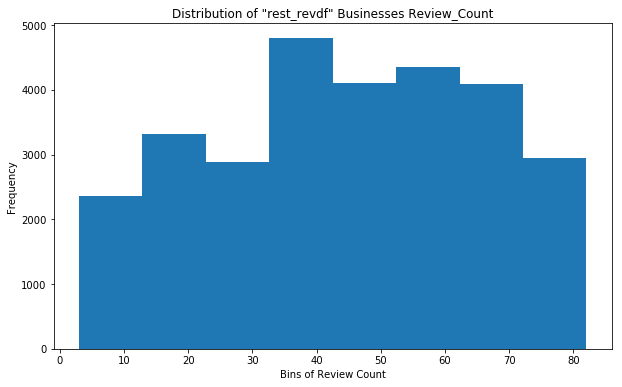

In [43]:
plt.figure(figsize=(10,6))
rest_revdf['total_reviews'].hist(bins = 8)
plt.title('Distribution of "rest_revdf" Businesses Review_Count')
plt.xlabel('Bins of Review Count')
plt.ylabel('Frequency')
plt.grid(None)
plt.show()

The distribution of `total_reviews` does not appear to be too skewed within the `rest_revdf` and has elements of a normal distribution, so I will briefly check its median valaue before deciding on a threshold.

In [44]:
rest_revdf['total_reviews'].median()

45.0

I could not find any publicly available total_review threshold Yelp may use to differentiate new or growing restaurants. However, I came across Yelp's "[new restaurants](https://www.yelp.com/nearme/new-restaurants)" webpage, and predominantly saw restaurants with a review count that normally does not surpass 50.

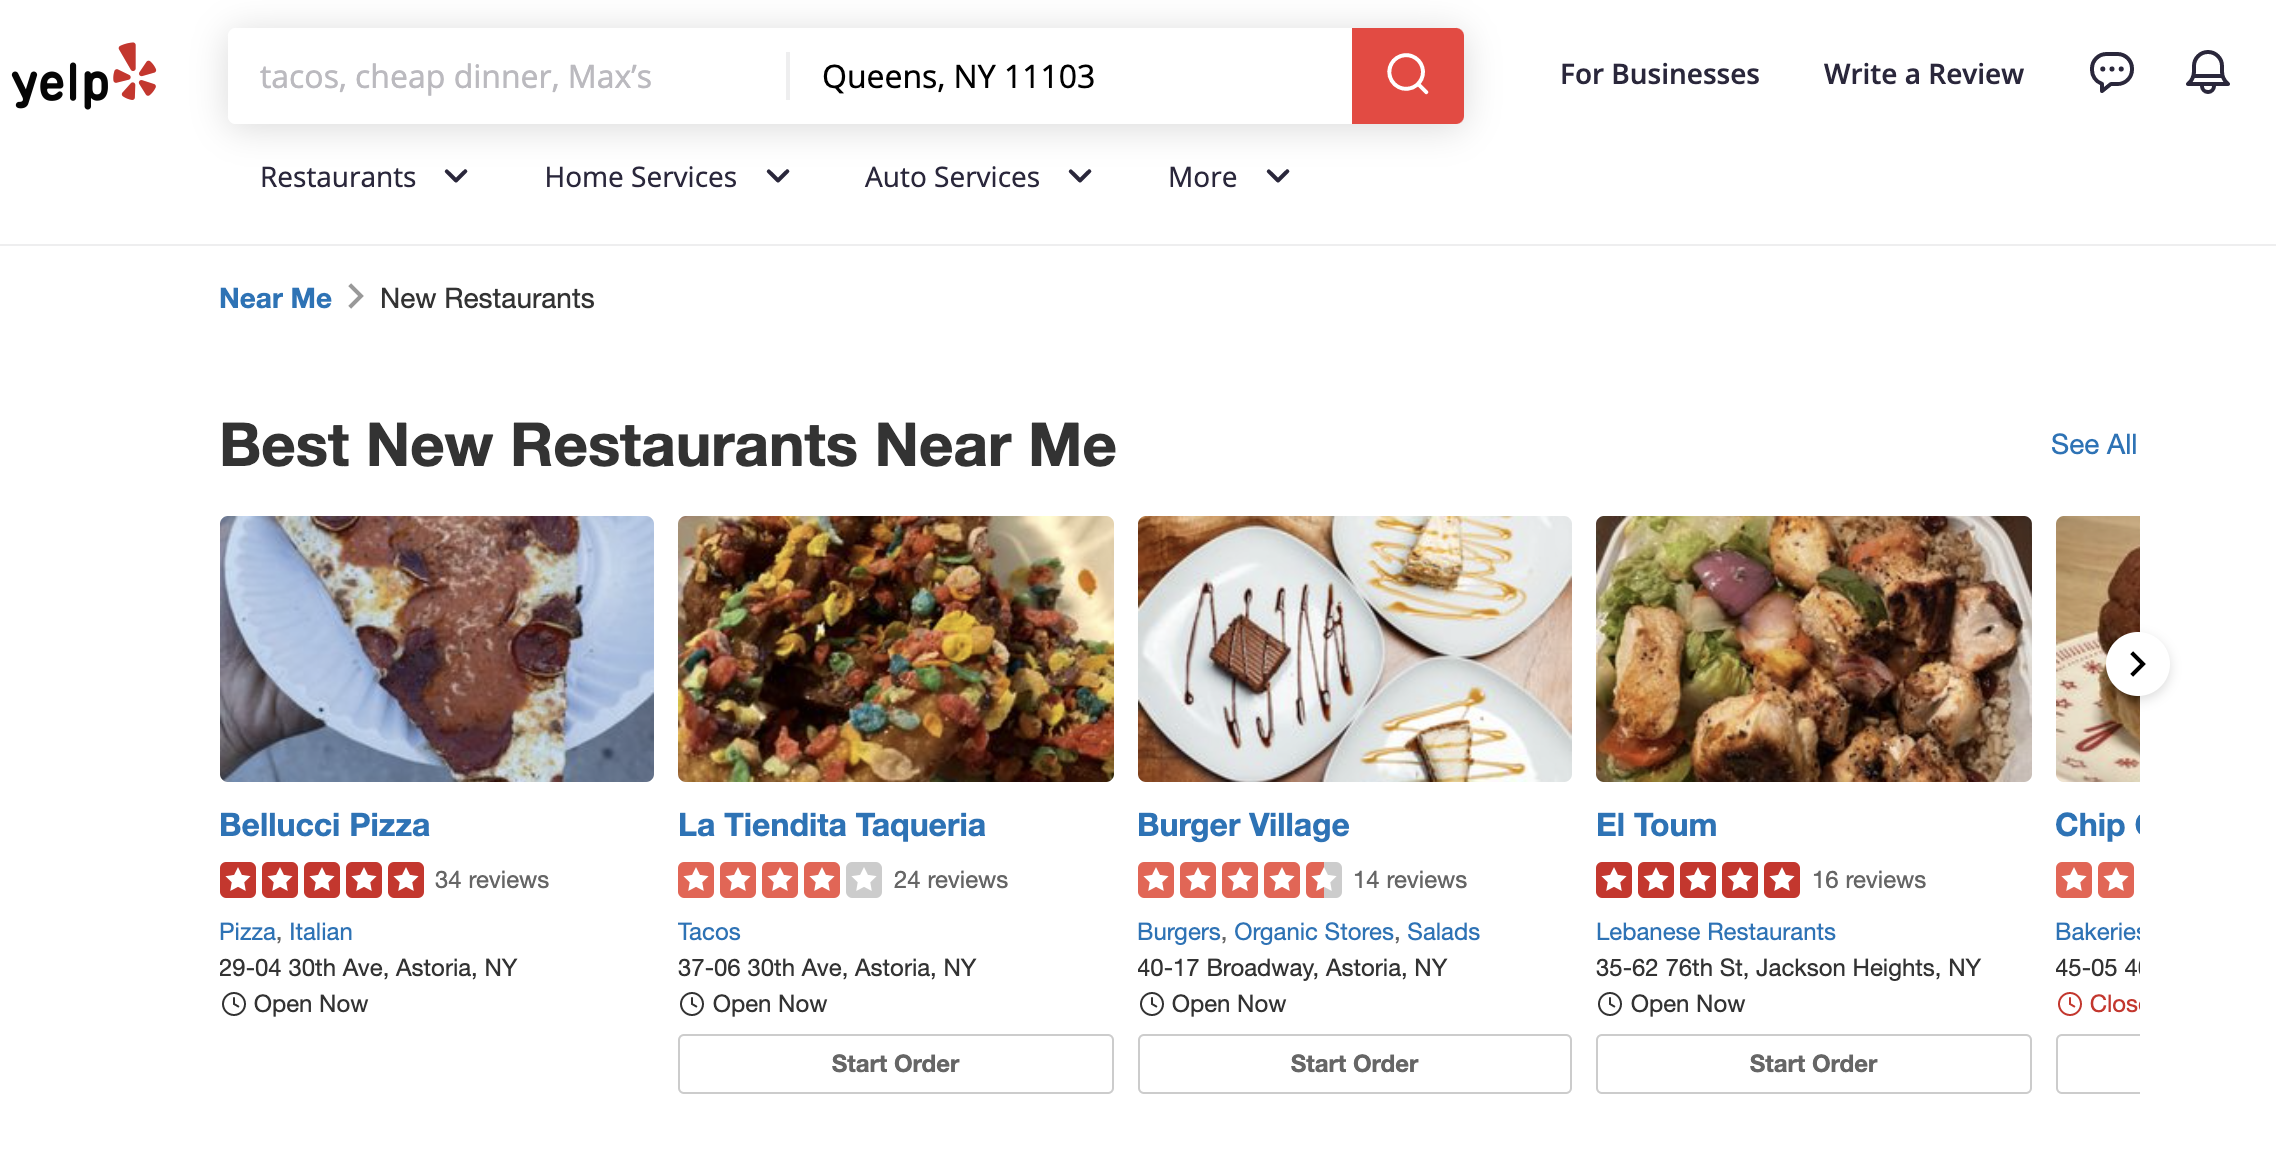

Because of the look into the `total_reviews` distribution and summary stats, along with the referenced Yelp webpage on new restaurants, I will opt to only include restaurants with a total review value of no more than **65** (about one standard distribution from the mean) for my final dataset that will be named `fin_restrev_df`.

In [45]:
# Updating the rest_revdf dataset to only have information of restaurants with total_reviews up to 65
fin_restrev_df = rest_revdf[rest_revdf['total_reviews'] <= 65]

# Resetting the index of the fin_restrev_df dataset
fin_restrev_df.reset_index(drop=True, inplace=True)

# Showing the first 3 rows of the final dataset
fin_restrev_df.head(3)

,review_id,user_id,business_id,review_stars,text,date,rest_name,address,city,state,postal_code,latitude,longitude,rest_avg_stars,total_reviews,is_open,attributes,categories,hours
0,JduSoCM6fn6a8EpfZoL4pg,4bxhIKz9ePWqD93UkEjnbg,NAigH4SqnuuQip8lekq7GQ,5,Another great Port of Subs experience! The XL ...,2017-01-27 21:39:23,Port of Subs,1855 W Deer Valley Rd,Phoenix,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
1,TJtAtX9wXYQP8TYghiOCew,XEHZoTDWjw3w-gcQyYIe4g,NAigH4SqnuuQip8lekq7GQ,3,I am not a huge sub fan to start with....\n\nT...,2009-05-27 20:12:59,Port of Subs,1855 W Deer Valley Rd,Phoenix,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."
2,mBuXcM08Tl57efVTfakIug,IC7NLIeWhS45_aEE_8aVUg,NAigH4SqnuuQip8lekq7GQ,5,The guy who helped me made very generous sandw...,2016-01-19 16:10:03,Port of Subs,1855 W Deer Valley Rd,Phoenix,AZ,85027,33.68318,-112.098636,3.5,60,1,"{'RestaurantsTakeOut': 'True', 'BusinessParkin...","Delis, Restaurants, Sandwiches","{'Monday': '9:0-19:0', 'Tuesday': '9:0-19:0', ..."


In [46]:
# Confirming the number of rows (reviews) mathes the sum of the total_review respective to each business
fin_restrev_df['business_id'].value_counts().sum() == fin_restrev_df.shape[0]

True

In [47]:
fin_restrev_df.transpose()

,0,1,2,3,4,5,6,7,8,9,...,22642,22643,22644,22645,22646,22647,22648,22649,22650,22651
review_id,JduSoCM6fn6a8EpfZoL4pg,TJtAtX9wXYQP8TYghiOCew,mBuXcM08Tl57efVTfakIug,fK-GXrlnAzWJt6S-R8lTFQ,B_Y-Qo5xkW19WdkPsbxImw,O7DUmVZ-x-7V1b8cU6vwNQ,Olf7QCysqpIFVdNxFHCk6Q,dBi72RtgC8oLYqrfoYQyDw,2ZuOKg9VHKZkOfaDyyqMVw,_yOmgMxutiUAYpmYT1SdHA,...,S-JItKpdFn_KW7FC0L2hKA,HnyldUHIMNklp57mEwCWig,A64SFz7QMuGgsvqJtAXBOw,0iAWDN3JITWl_s5HMHe9vw,_3r7QUaOgv4tX7Klo97SFA,2xPdQZ0ojl7KtlzuzwkcFg,3N5wxeBFAvpBwRA8sSix_A,r2LLBmatI5kh1eSppNB2ng,rr7AlDqINphOitshZPykZg,vZ4wF8XxftxaSkzfmWAT1g
user_id,4bxhIKz9ePWqD93UkEjnbg,XEHZoTDWjw3w-gcQyYIe4g,IC7NLIeWhS45_aEE_8aVUg,1zj0n7gyJ0jmWfYQRhvstA,T6Gti8sicxZZ28fuS1JFKA,llrtsdPpcCdbOME_ogo2jQ,jKZCN7YsaIcyKSVTEQxclw,ZfQvdfyGe5nwr2a2UuUBTA,XZ8qucmEm-yOHXlxCT3-Ww,v81uefRu-Nz8a4YiVaA8JQ,...,pRsOP8VuAeaJYCEeNf7HyQ,UCX3T-ei7vNKvmt3HwoviQ,h6pg3HHtVMBI8CIAZKW5Ug,yKBenWMLCe5UBVi_gXWIBA,nxWarv4wVw9E4JP1-7YJMA,DPitNu466172os6m0Yri1Q,ZRDh_86bbknHNGsmXNi2gA,KrAiU8OyuQlXglpAEgYeBg,5Fw6Qlj2x6fOiooZEnedmA,Es9ldEGui_e2MprdcNbt_Q
business_id,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,NAigH4SqnuuQip8lekq7GQ,...,ycSoCwxbrlC4fXHaF8MbCw,xnxdFEIsNjbrX16V4t-BRQ,btyZdQtebHDMbv5zg6Y--g,gJWdhHT0E0LPxXxARWzB9A,h6cCARL_ngx7OM1NEu1E_g,nUYFVybkp6HqY4wf8sNy5A,EVIgcyBM4QQGi_zQ8W-Zgg,EVIgcyBM4QQGi_zQ8W-Zgg,npFreYuGvPtNbHo0x74zcA,b5OTjiOjEg_UkmObTVnf2A
review_stars,5,3,5,5,1,5,5,4,3,1,...,5,5,1,5,4,1,4,5,5,2
text,Another great Port of Subs experience! The XL ...,I am not a huge sub fan to start with....\n\nT...,The guy who helped me made very generous sandw...,Mmmmmmmmm one of my favorite sandwich location...,I'm not a meat person but they put almost NO m...,I LOVE these sandwiches! OMG they are deliciou...,Used to be such terrible service here back in ...,Sliced by hand meats start your order with fre...,Once Again a contender with Subway and Quiznos...,We ordered a 6 foot sub with multiple types of...,...,Very friendly staff & the juices are superb! W...,Happy they have a Yelp page bc I really love g...,I live close to this bakery and barely went t...,Yum! Stopped in for a quick to go strawberry b...,The sandwiches here are super delicious! Howev...,Came in on a Sunday. Place was jam packed. Tub...,"I got three tacos (deep fried fish, grilled ch...",Best bean and cheese burrito around and I am a...,My family and I used to live nearby and we use...,Came here for a quick lunch - my first time in...
date,2017-01-27 21:39:23,2009-05-27 20:12:59,2016-01-19 16:10:03,2014-07-16 15:56:18,2013-02-04 05:31:28,2014-05-10 16:50:14,2016-10-27 23:39:16,2015-06-15 04:10:24,2008-09-01 20:35:35,2015-07-19 00:00:11,...,2019-06-10 20:16:53,2019-12-09 23:27:03,2016-01-06 18:48:25,2019-03-31 18:20:14,2019-10-24 17:36:42,2019-07-14 21:50:29,2019-12-01 01:30:33,2019-11-11 01:19:15,2016-02-27 15:22:28,2019-11-09 05:09:05
rest_name,Port of Subs,Port of Subs,Port of Subs,Port of Subs,Port of Subs,Port of Subs,Port of Subs,Port of Subs,Port of Subs,Port of Subs,...,Tropical Juices,Bop And Roll,El Fenix Bakery,Hempful Farms Cafe,Zookz Sandwiches,La Botana,Senor Taco Express,Senor Taco Express,The Adobe Restaurant,Schlotzsky's
address,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,1855 W Deer Valley Rd,...,3923 E Thomas Rd,"7000 E Mayo Blvd, Ste 1086",6219 S Central Ave,1756 W Bell Rd,"4000 E Sky Harbor Blvd, Gate B9 in terminal 4 ...","4344 W Indian School Rd, Ste 34","4539 E Thomas Rd, Ste B105","4539 E Thomas Rd, Ste B105",2400 E Missouri Ave,4445 E Thomas Rd
city,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,...,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix,Phoenix
state,AZ,AZ,AZ,AZ,AZ,AZ,AZ,AZ,AZ,AZ,...,AZ,AZ,AZ

In [48]:
# Number of restaurants in final restaurant+reviews dataset
len(fin_restrev_df['business_id'].unique())

948

In [49]:
# Number of unique reviewers in final restaurant+reviews dataset
len(fin_restrev_df['user_id'].unique())

17615

-------

## Implementing the Matrix Factorization FunkSVD Model

First, I will create a DataFrame containing only the UserIDs of the reviewers, business_id's of the restaurants, and ratings left per review from my `fin_restrev_df` dataset. The DataFrame will be called `user_rest_rating_df`, and be sorted based on `user_id` given that the FunkSVD model assigns each user with a value starting at 0 based on the order it sees them in.

In [50]:
# Getting a dataset with ONLY the reviewer, restaurant, and rating
user_rest_rating_df = fin_restrev_df[['user_id', 'business_id', 'review_stars']]
user_rest_rating_df

,user_id,business_id,review_stars
0,4bxhIKz9ePWqD93UkEjnbg,NAigH4SqnuuQip8lekq7GQ,5
1,XEHZoTDWjw3w-gcQyYIe4g,NAigH4SqnuuQip8lekq7GQ,3
2,IC7NLIeWhS45_aEE_8aVUg,NAigH4SqnuuQip8lekq7GQ,5
3,1zj0n7gyJ0jmWfYQRhvstA,NAigH4SqnuuQip8lekq7GQ,5
4,T6Gti8sicxZZ28fuS1JFKA,NAigH4SqnuuQip8lekq7GQ,1
...,...,...,...
22647,DPitNu466172os6m0Yri1Q,nUYFVybkp6HqY4wf8sNy5A,1
22648,ZRDh_86bbknHNGsmXNi2gA,EVIgcyBM4QQGi_zQ8W-Zgg,4
22649,KrAiU8OyuQlXglpAEgYeBg,EVIgcyBM4QQGi_zQ8W-Zgg,5
22650,5Fw6Qlj2x6fOiooZEnedmA,npFreYuGvPtNbHo0x74zcA,5


In [51]:
# sorting the dataset on UserIDs
user_rest_rating_df = user_rest_rating_df.sort_values(by=['user_id', 'business_id'])
user_rest_rating_df.head()

,user_id,business_id,review_stars
11515,--2HUmLkcNHZp0xw6AMBPg,Dj4AepxMBS-5DUvPegSb2g,5
20460,--2HUmLkcNHZp0xw6AMBPg,QILXFNxJIRE5rcmLHl0zag,1
6382,--2HUmLkcNHZp0xw6AMBPg,TdupOOzuT917Ps3g6X2GTA,5
20301,--2HUmLkcNHZp0xw6AMBPg,YnF2EwefB-sNd_S4xHBmGA,5
2556,--2HUmLkcNHZp0xw6AMBPg,bBM6OguT_lLYSlq4NaMuzw,5


Secondly, I will import the relevant python packages containing model in queston and its relvant classes. It will be the `surprise` package. 

The `user_rest_rating_df` DataFrame will be loaded onto a special `surprise` object called `Dataset`.

In [52]:
from surprise import Dataset
from surprise.reader import Reader
from surprise.prediction_algorithms.matrix_factorization import SVD as FunkSVD
from surprise import accuracy

In [53]:
# Loading the Reader `surprise` classifier and Dataset classifier to bass the above rating dataframe into
my_reader = Reader(rating_scale=(1,5))

my_sur_dataset = Dataset.load_from_df(user_rest_rating_df, my_reader)
my_sur_dataset

## Hyperparameter Optimization via the use of `GridSearchCV`

Before I fit my FunkSVD model onto `my_sur_dataset`, I will opt to use the `GridSearchCV` function from the `surprise` package, which helps find the optimal parameter values for a passed model and evaluation metric based on a set of parameter values of one's choice. 

The main parameters of interest to optimize are: 
- `n_factors`: represents the number of latent variables or embeddings desired to learn
- `n_epochs`: represents the number of iterations the algorithm should run for
- `lr_all`: represents the learning rate for all parameters
    - In an optimization algorithm setting, the learning rate controls how much we are adjusting the weights of our network with respect the loss gradient per this [resourse](https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10). In other words, it affects how quickly our model can converge to a local minima (aka arrive at the best accuracy).

(bonus: this parameter will not be optimized, but a brief breakdown on what it does can be found below)
- `biased`: this parameter allows us to use the [Probablistic](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#unbiased-note) version of Matrix Factorization, by setting its value to `False`. It also forces the algorithm to store all latent information in the matrices.


## Evaluation Metric for the Algorithm's Performance: FCP

I will use a ranking-based metric called the Fraction of Concordant Pairs (FCP) to evaluate my model. The FCP metric is composed of concordant pairs that contain pairs of both known (true) and predicted ratings, which work to imply that if the known rating of Restaurant A is > the known rating of Restaurant B, then the **predicted** rating of Restaurant A will also be greater than that of Restaurant B. FCP is the ratio of concordant rating pairs to all rating pairs, such that its score ranges between 1 (best) and 0 (worst).

In [54]:
# Importing the GridSearchCV classifier for SVD parameter tuning
from surprise.model_selection import GridSearchCV

In [55]:
# Setting the parameter grid
param_grid = {
    # Default value is 100
    'n_factors': [75, 100, 125], 
    # Default value is 20
    'n_epochs': [20, 25, 30],
    # Default value is 0.005
    'lr_all': [0.005, 0.01, 0.1],
    'biased': [False]
}

# Setting the GridSearchCV classifier with 5 cross validation
GS = GridSearchCV(FunkSVD, param_grid, measures=['fcp'], cv=5)

# Fitting the model on the various parameter values from the created grid
GS.fit(my_sur_dataset)

In [56]:
gsbs = GS.best_score['fcp']
gsbp = GS.best_params['fcp']

print(f'The best evaluated FCP score using the parameter grid values is: {gsbs}.')
print('\n')
print(f"The optimal parameter values from the parameter grid for the FunkSVD model's performance on the dataset are: {gsbp}.")

The best evaluated FCP score using the parameter grid values is: 0.5454586336423739.


The optimal parameter values from the parameter grid for the FunkSVD model's performance on the dataset are: {'n_factors': 100, 'n_epochs': 25, 'lr_all': 0.1, 'biased': False}.


-----

Based on the GridSearch's results, the optimal parameters for model performance on the `my_sur_dataset` dataset are in the cell above. 

The results of the FCP score is about 0.55. Though the value could've certainly been better, the result is not terrible given the size of the training set (over 22,000 records).

I will now import the `train_test_split` classifier to build the FunkSVD model on both a train and test dataset to assess the accuracy of the predicted ratings on the set of **known** ratings.

In [57]:
from surprise.model_selection import train_test_split

In [58]:
# Split train test set
trainset, testset = train_test_split(my_sur_dataset, test_size=0.4)

# Instantiating the FunkSVD algorithm
my_funksvd = FunkSVD(n_factors=100,
                    n_epochs=25,
                    lr_all=0.1,
                    biased=False)

# Fitting the train set on the model
my_funksvd.fit(trainset)

# Testing the algorithm on the test dataset
my_predictions = my_funksvd.test(testset)

In [59]:
# Creating a dataframe from the prediction results on the TEST set
predictions_df = pd.DataFrame(my_predictions, columns=['user_id', 'business_id', 'actual_rating', 'prediction', 'details'])

# Appending a column to the predictions_df DataFrame for the difference between known and predicted ratings of it
    # as an absolute value for the difference
predictions_df['rating_diff'] = abs(predictions_df['prediction']-predictions_df['actual_rating'])

In [60]:
# Getting a look at the predictions_df dataset
predictions_df.head(6)

,user_id,business_id,actual_rating,prediction,details,rating_diff
0,7XuVVfMBmePoYjSKVQwa3A,19LQmaLOi22V5RrI3eB5lA,5.0,1.000000,{'was_impossible': False},4.000000
1,KKge9LnT43L8C3PQz8I2zg,EWo5usxVpjAs25NFBbsITQ,5.0,3.470311,"{'was_impossible': True, 'reason': 'User and i...",1.529689
2,k1yP9hHka_xg-AW14M8V0Q,ZqNuleQMaEBYjAPVeaKrug,1.0,3.470311,"{'was_impossible': True, 'reason': 'User and i...",2.470311
3,c2eweAnxe89YBfz2Oa_MLQ,rT8DwZu7pvuWKRM1nwVuug,5.0,3.470311,"{'was_impossible': True, 'reason': 'User and i...",1.529689
4,sNr5ODRUhMj7mp-0jpbsEQ,E7wKP-BVnWlxnbQM3StOxg,5.0,3.470311,"{'was_impossible': True, 'reason': 'User and i...",1.529689
5,foDSVja3cCgCoLDzilpyTw,npFreYuGvPtNbHo0x74zcA,4.0,1.000000,{'was_impossible': False},3.000000


In [61]:
(predictions_df['rating_diff'] == 0).mean()

0.037744178346760845

About ~3.8% of the ratings were predicted accurately according the function above. However, because the rating and prediction columns are of `float` datatype, a single variation in an integer will make the prediction not be immediately equal to its respective known rating.

Below I will expand the level of difference threshold to be within -/+1, meaning I will include predictions which came within 1 of its actual rating.

In [62]:
(predictions_df['rating_diff'] <= 1).mean()

0.24831696280763713

About 25% of the predicted ratings are within a 1-point rating difference of their respective **known** rating, which again is not too bad given the size of the test set.


Great! Now that I know the optimal parameter values, based on the listed options in the parameter grid, for the `my_sur_dataset` surprise Dataset classifier and ran the model on a test set of known ratings to best predict those values; I will fit the model to the **full** training dataset below.

In [75]:
# Creating the full training set using Surprise's 'build_full_trainset' method
full_trainset = my_sur_dataset.build_full_trainset()

# Instantiating the SVD model using the optimal parameter values
my_fsvd = FunkSVD(n_factors=100,
                  n_epochs=25,
                  lr_all=0.1,
                  biased=False)

# Fitting the SVD model to the full training dataset
my_fsvd.fit(full_trainset)

Because the intent of my recommender system is to suggest restaurants with variety, I will use `my_fsvd` model to create a test dataset of predicted ratings for restaurants that reviewers have not visited (i.e. without any ratings). To do this, I will leverage the `build_anti_testset` method from the `surprise` package.

In [76]:
# Creating a full testing set, using the previously created 'full_trainset', and including a '-1' value placeholder
    # for the "actual_rating" column
full_testset = full_trainset.build_anti_testset(fill=-1)

# Using the model to create the prediction values for the restaurants respective users have not reviewed
my_pred = my_fsvd.test(full_testset)


I will now create a DataFrame for the predicted values of unknown ratings for Reviewer and Restaurant combinations that have not occurred.

In [77]:
unvisited_pred_df = pd.DataFrame(my_pred, columns=['user_id', 'business_id', 'actual_rating', 'prediction', 'details'])

# Getting a look at the 15 highest predicted Restaurant Review rating for unvisited (unkown) values
unvisited_pred_df.sort_values(by=['prediction'], ascending=False).head(15)

,user_id,business_id,actual_rating,prediction,details
13137295,m6jFUhsWWpDlAbv8q3awqw,BxNhwgVNi2qsAco8388h5A,-1.0,5.000000,{'was_impossible': False}
16658785,zv0MVTY5PTYb1O7KqVTIuw,1i5XUF2UJyN181z7ObStjQ,-1.0,4.978998,{'was_impossible': False}
9370650,YcnvGVR_xPMQlZ-PrGLl1g,1i5XUF2UJyN181z7ObStjQ,-1.0,4.966517,{'was_impossible': False}
8662054,W4ZuWztx47aiksyYPUMYDw,WDdY2RWTTz5w81riEG8AFQ,-1.0,4.953425,{'was_impossible': False}
813548,24AzZDQKHySwMQR7VQVCAg,pmpJS5skJj14y5brPPI2ew,-1.0,4.911501,{'was_impossible': False}
2758505,9mZ9ACKd6ujaSoT54WKr1w,1i5XUF2UJyN181z7ObStjQ,-1.0,4.877911,{'was_impossible': False}
2139333,7GVA958q4zs5Z8cdHauU5Q,1i5XUF2UJyN181z7ObStjQ,-1.0,4.831397,{'was_impossible': False}
6458446,NkDoHXaKJaCtrjWh9zDvJQ,1i5XUF2UJyN181z7ObStjQ,-1.0,4.762723,{'was_impossible': False}
12413258,jHONHSh8BHkmDARrfcoCGg,saojSJ2tJn04PLHDbOT6qg,-1.0,4.600964,{'was_impossible': False}
5103631,IjWOxi19ijj88BKi3pCj9A,1i5XUF2UJyN181z7ObStjQ,-1.0,4.552051,{'was_impossible': False}


In [78]:
print(f'The amount of unreviewed, Reviewer and unvisited Restaurant, combinations are: {unvisited_pred_df.shape[0]}.')

The amount of unreviewed, Reviewer and unvisited Restaurant, combinations are: 16677026.


Finally, I will merge the dataset, `fin_restrev_df`, containing the Review (i.e. rating, text of review, etc.) and Restaurant (i.e. address, categories, hours, etc.) information to the `unvisited_pred_df` dataset. 

The importance of this step is that it will allow us to attribute restaurant information, mainly the `categories` feature to allow my recommendation system to use its information as user-input for preferences of suggestes restaurants.

In [79]:
pred_rtg_rst_df = unvisited_pred_df.merge(fin_restrev_df[['business_id', 'rest_name', 'address','city', 'state', 'postal_code', \
                'latitude', 'longitude', 'rest_avg_stars','total_reviews', 'categories']].drop_duplicates(), \
                how='left', left_on=['business_id'], right_on=['business_id'])

print(f'Confirming the left join/merge keeps the number of rows of the "unvisited_pred_df" dataset: {pred_rtg_rst_df.shape[0]}.')
print('\n')
pred_rtg_rst_df.head(10)

Confirming the left join/merge keeps the number of rows of the "unvisited_pred_df" dataset: 16677026.




,user_id,business_id,actual_rating,prediction,details,rest_name,address,city,state,postal_code,latitude,longitude,rest_avg_stars,total_reviews,categories
0,--2HUmLkcNHZp0xw6AMBPg,ycAmQ9kRi5iB9OyJONacBQ,-1.0,1.000000,{'was_impossible': False},Paradise Bakery & Cafe,3000 E Sky Harbor Blvd,Phoenix,AZ,85034,33.435693,-112.013795,1.5,55,"Food, Sandwiches, Restaurants, Coffee & Tea, B..."
1,--2HUmLkcNHZp0xw6AMBPg,DE37j9FjAfysF5q7jQ507Q,-1.0,1.000000,{'was_impossible': False},Mayo Clinic Hospital Cafeteria,5777 E Mayo Blvd,Phoenix,AZ,85054,33.658619,-111.956581,3.5,47,"Ice Cream & Frozen Yogurt, Hospitals, American..."
2,--2HUmLkcNHZp0xw6AMBPg,Q6nhycv6JGREujknLYz2wg,-1.0,1.175736,{'was_impossible': False},Someburros,5115 N 7th St,Phoenix,AZ,85014,33.511653,-112.064556,3.5,52,"Mexican, Restaurants"
3,--2HUmLkcNHZp0xw6AMBPg,sYmGrCydqABvGmundtZ6gg,-1.0,1.000000,{'was_impossible': False},Domino's Pizza,2819 N Central Ave,Phoenix,AZ,85004,33.479503,-112.073300,2.5,48,"Restaurants, Pizza, Chicken Wings, Sandwiches"
4,--2HUmLkcNHZp0xw6AMBPg,CopCF0_RumhBLIIB7eNyxA,-1.0,1.000000,{'was_impossible': False},27th Ave Bar n Grill,2038 N 27th Ave,Phoenix,AZ,85009,33.470912,-112.117569,3.5,45,"Nightlife, Restaurants, Bars, American (New)"
5,--2HUmLkcNHZp0xw6AMBPg,zsNEni7cr4lRnjd4AcO4kA,-1.0,3.006787,{'was_impossible': False},Rolberto's Taco Shop,12831 N Cave Creek Rd,Phoenix,AZ,85022,33.603512,-112.036343,4.0,34,"Restaurants, Mexican"
6,--2HUmLkcNHZp0xw6AMBPg,kQbo5EmBXphXfLFddMqsug,-1.0,1.836115,{'was_impossible': False},The Courtyard Cafe at Heard Museum,2301 N Central Ave,Phoenix,AZ,85004,33.472474,-112.072201,4.5,40,"American (Traditional), Cafes, Restaurants"
7,--2HUmLkcNHZp0xw6AMBPg,e2DH7QQssuGqwLltAI5pEg,-1.0,1.000000,{'was_impossible': False},Humphrey's Kitchen & Koffee,"4742 N 24th St, Ste A-100",Phoenix,AZ,85016,33.507231,-112.030784,4.5,24,"Delis, Restaurants, Breakfast & Brunch, Sandwi..."
8,--2HUmLkcNHZp0xw6AMBPg,-H1-IzxW6CXmjhmF5F6iMA,-1.0,1.000000,{'was_impossible': False},Green Tea Chinese Restaurant,"3961 E Chandler Blvd, Ste 100",Phoenix,AZ,85048,33.303658,-111.998465,3.5,64,"Chinese, Restaurants"
9,--2HUmLkcNHZp0xw6AMBPg,1DdkhCSmKDgFmilXS9SZEA,-1.0,1.000000,{'was_impossible': False},El Pacifico Restaurante Y Pescaderia,3311 N 16th St,Phoenix,AZ,85016,33.486221,-112.047383,4.0,47,"Mexican, Restaurants, Seafood"


I will briefly the following changes to the `pred_rtg_rst_df` dataset for feasibility in using it in the recommender system:
- Dropping the 'actual_rating' column for this predictive dataset as we don't know it, in addtion to the 'details' column
- Adding a column for the difference between 'rest_avg_stars' and 'prediction' rating to help get a better sense of the error of my model's predictions and what the Restaurant on average receives in rating assessments
- Reordering column appearance in the dataset

In [80]:
# dropping the referenced columns
pred_rtg_rst_df.drop(columns=['actual_rating', 'details'], inplace=True)

# Creating the column for the difference between restaurant's average star rating and my predicted ratings
    # for these unreviewed restaurant respective the reviewer's that have not rated them
pred_rtg_rst_df['avg_pred_rtg_difference'] = abs(pred_rtg_rst_df['rest_avg_stars']-pred_rtg_rst_df['prediction'])

# Reordering the columns as desired
pred_rtg_rst_df = pred_rtg_rst_df[['user_id', 'business_id', 'prediction', 'rest_avg_stars', 'avg_pred_rtg_difference', 'rest_name', \
                'categories', 'address', 'city', 'state', 'postal_code', 'latitude', 'longitude','total_reviews']]

# Showing the resulting dataset post-updates
pred_rtg_rst_df

,user_id,business_id,prediction,rest_avg_stars,avg_pred_rtg_difference,rest_name,categories,address,city,state,postal_code,latitude,longitude,total_reviews
0,--2HUmLkcNHZp0xw6AMBPg,ycAmQ9kRi5iB9OyJONacBQ,1.000000,1.5,0.500000,Paradise Bakery & Cafe,"Food, Sandwiches, Restaurants, Coffee & Tea, B...",3000 E Sky Harbor Blvd,Phoenix,AZ,85034,33.435693,-112.013795,55
1,--2HUmLkcNHZp0xw6AMBPg,DE37j9FjAfysF5q7jQ507Q,1.000000,3.5,2.500000,Mayo Clinic Hospital Cafeteria,"Ice Cream & Frozen Yogurt, Hospitals, American...",5777 E Mayo Blvd,Phoenix,AZ,85054,33.658619,-111.956581,47
2,--2HUmLkcNHZp0xw6AMBPg,Q6nhycv6JGREujknLYz2wg,1.175736,3.5,2.324264,Someburros,"Mexican, Restaurants",5115 N 7th St,Phoenix,AZ,85014,33.511653,-112.064556,52
3,--2HUmLkcNHZp0xw6AMBPg,sYmGrCydqABvGmundtZ6gg,1.000000,2.5,1.500000,Domino's Pizza,"Restaurants, Pizza, Chicken Wings, Sandwiches",2819 N Central Ave,Phoenix,AZ,85004,33.479503,-112.073300,48
4,--2HUmLkcNHZp0xw6AMBPg,CopCF0_RumhBLIIB7eNyxA,1.000000,3.5,2.500000,27th Ave Bar n Grill,"Nightlife, Restaurants, Bars, American (New)",2038 N 27th Ave,Phoenix,AZ,85009,33.470912,-112.117569,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16677021,zzJImcfBJi_SJSuh-6l2qw,PBsFm2VoOQIglTjqwKgYZQ,1.000000,4.5,3.500000,Cafe Eden,"Cafes, Nightlife, Restaurants, Wine Bars, Bars...",1401 E Jefferson St,Phoenix,AZ,85034,33.445938,-112.051689,3
16677022,zzJImcfBJi_SJSuh-6l2qw,qVpfhkHMvF9Rlwe9dqPlBg,1.076715,3.5,2.423285,Carniceria Mi Casita,"Mexican, Restaurants, Meat Shops, Food, Specia...",4203 N 19th Ave,Phoenix,AZ,85015,33.496096,-112.099603,3
16677023,zzJImcfBJi_SJSuh-6l2qw,dNPGKF7CeZRB9x37b7rYVw,1.000000,3.0,2.000000,Mr. Cafe,"Hawaiian, Seafood, Ramen, Restaurants, Japanes...","3202 E Greenway Rd, Ste 1613",Phoenix,AZ,85032,33.627475,-112.012243,4
16677024,zzJImcfBJi_SJSuh-6l2qw,9NDWU7w-Pau6gZwAxnJucw,1.000000,3.5,2.500000,Red Rim Bistro,"Restaurants, Burgers, American (New)",1101 N 44th St,Phoenix,AZ,85008,33.460207,-111.985532,6


I now have information on known ratings, via `fin_restrev_df`, and information of predicted ratings for Reviewers that have not been to respective Restaurants in `pred_rtg_rst_df`; and can begin to work on creating my recommender system.

-------

## Creating the Recommendation System

Before I get into bulding the system, I want to take a look at the distribution of values among the `avg_pred_rtg_difference` and `rest_avg_stars` columns to decide on what rating threshold I may want to apply in the system that will in turn populate restaurants that match this threshhold; AND `categories` input value.

In [81]:
# Summary stats for the respective columns
pred_rtg_rst_df[['prediction', 'rest_avg_stars', 'avg_pred_rtg_difference', 'total_reviews']].describe().apply(lambda s: s.apply('{0:.5f}'.format))

,prediction,rest_avg_stars,avg_pred_rtg_difference,total_reviews
count,16677026.00000,16677026.00000,16677026.00000,16677026.00000
mean,1.01142,3.48104,2.46966,23.87772
std,0.08096,0.92797,0.92783,17.50012
min,1.00000,1.00000,0.00000,3.00000
25%,1.00000,3.00000,2.00000,9.00000
50%,1.00000,3.50000,2.50000,19.00000
75%,1.00000,4.00000,3.00000,37.00000
max,5.00000,5.00000,4.00000,65.00000


Constructing the model:

In [82]:
# Getting a sub-dataset of reviews on restaurants CONTAINING search word
prd_cat_df = pred_rtg_rst_df[pred_rtg_rst_df['categories'].str.contains('Breakfast', case=False)]
prd_cat_df

,user_id,business_id,prediction,rest_avg_stars,avg_pred_rtg_difference,rest_name,categories,address,city,state,postal_code,latitude,longitude,total_reviews
7,--2HUmLkcNHZp0xw6AMBPg,e2DH7QQssuGqwLltAI5pEg,1.000000,4.5,3.500000,Humphrey's Kitchen & Koffee,"Delis, Restaurants, Breakfast & Brunch, Sandwi...","4742 N 24th St, Ste A-100",Phoenix,AZ,85016,33.507231,-112.030784,24
22,--2HUmLkcNHZp0xw6AMBPg,cLeH08WoBoozrRco89i9Nw,1.000000,4.0,3.000000,Let's Do Lunch,"Restaurants, American (New), Breakfast & Brunc...","2320 W Peoria Ave, Ste A107",Phoenix,AZ,85029,33.583323,-112.108797,22
30,--2HUmLkcNHZp0xw6AMBPg,-LbNfYuwyvTDFjh7TFygug,1.000000,3.5,2.500000,la Madeleine French Bakery & Cafe,"Food, Bakeries, Caterers, Cafes, French, Resta...","45 W Jefferson St, Ste M",Phoenix,AZ,85003,33.446960,-112.074924,54
36,--2HUmLkcNHZp0xw6AMBPg,Q08j1Ywri0YUHo-qLKi80g,1.433577,4.0,2.566423,Burger Shoppe,"Breakfast & Brunch, Mexican, Burgers, Restaurants",151 N 27th Ave,Phoenix,AZ,85009,33.450544,-112.117196,34
57,--2HUmLkcNHZp0xw6AMBPg,g-aAe8SqZlZTnN3oA8mNlw,1.000000,2.0,1.000000,Del Taco,"Restaurants, Mexican, Food, Desserts, Breakfas...",4252 S 48th St,Phoenix,AZ,85040,33.407691,-111.978612,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16676955,zzJImcfBJi_SJSuh-6l2qw,A6qLlVs7kR8fxlZmQ_Zecw,1.000000,3.5,2.500000,Metro Cafe,"Mexican, Wraps, Breakfast & Brunch, Sandwiches...","10000 N 31st Ave, Ste A106",Phoenix,AZ,85051,33.577240,-112.127022,3
16676956,zzJImcfBJi_SJSuh-6l2qw,RVA_8u3ryBecW0Q6Vk7n4w,1.000000,3.0,2.000000,AZ Metro Cafe,"American (Traditional), Restaurants, Cafes, Br...",18444 N 25th Ave,Phoenix,AZ,85023,33.653719,-112.112964,8
16676957,zzJImcfBJi_SJSuh-6l2qw,SI_YvWQyHz2riuFJgYUxfw,1.000000,4.0,3.000000,Berta El Sabor de Los Mochis,"Mexican, Restaurants, Food, Sushi Bars, Seafoo...",1212 S 28th Ave,Phoenix,AZ,85009,33.436407,-112.119760,11
16676975,zzJImcfBJi_SJSuh-6l2qw,olcmJozm8Oq0yTQHGAJYfw,1.000000,3.0,2.000000,The Post,"Event Planning & Services, Food, Breakfast & B...",4300 E Washington St,Phoenix,AZ,85034,33.448863,-111.988439,11


In [83]:
# filtering UNknown reviews by a avg_pred_rtg_difference threshold
thrs_prd_cat_df = prd_cat_df[prd_cat_df['avg_pred_rtg_difference'] <= 2]
thrs_prd_cat_df

,user_id,business_id,prediction,rest_avg_stars,avg_pred_rtg_difference,rest_name,categories,address,city,state,postal_code,latitude,longitude,total_reviews
57,--2HUmLkcNHZp0xw6AMBPg,g-aAe8SqZlZTnN3oA8mNlw,1.000000,2.0,1.000000,Del Taco,"Restaurants, Mexican, Food, Desserts, Breakfas...",4252 S 48th St,Phoenix,AZ,85040,33.407691,-111.978612,42
61,--2HUmLkcNHZp0xw6AMBPg,ZRdHKIjiIa0k5-ufCLyIaQ,1.000000,2.5,1.500000,Denny's,"American (Traditional), Breakfast & Brunch, Am...",2525 W Deer Valley Rd,Phoenix,AZ,85027,33.683338,-112.114942,53
80,--2HUmLkcNHZp0xw6AMBPg,yvNwuGauuPn1U9bIpyVlHQ,1.000000,2.0,1.000000,Denny's,"Breakfast & Brunch, Restaurants, Diners, Ameri...",6700 W Latham St,Phoenix,AZ,85043,33.461080,-112.204556,36
94,--2HUmLkcNHZp0xw6AMBPg,30PzafMyWvh5fYZ8yV_qBg,1.320891,3.0,1.679109,Lunch Box,"Diners, Breakfast & Brunch, Mexican, American ...",2539 W Bethany Home Rd,Phoenix,AZ,85017,33.523727,-112.113875,61
138,--2HUmLkcNHZp0xw6AMBPg,XiHEGZlZGF8xrjxC6iM3sg,1.000000,2.0,1.000000,Denny's,"Diners, American (Traditional), Restaurants, B...",4120 N 51st Ave,Phoenix,AZ,85031,33.495882,-112.169249,37
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16676861,zzJImcfBJi_SJSuh-6l2qw,rhT_1TbKu_gsFL-WCUUujQ,1.000000,2.5,1.500000,Filiberto's Mexican Food,"Specialty Food, Mexican, Imported Food, Ethnic...",3510 W. Southern Ave,Phoenix,AZ,85041,33.392438,-112.135760,33
16676906,zzJImcfBJi_SJSuh-6l2qw,_gcdr8xuRGBgJ7wIOxNFvQ,1.000000,3.0,2.000000,Indigo Bistro,"Comfort Food, Restaurants, American (Tradition...",2620 W Dunlap Ave,Phoenix,AZ,85021,33.568589,-112.115467,6
16676937,zzJImcfBJi_SJSuh-6l2qw,R0dGJZYGAgYhr19CScTjYg,1.000000,3.0,2.000000,Biscuits,"American (Traditional), Mexican, Restaurants, ...",4623 E Elliot Rd,Phoenix,AZ,85044,33.348566,-111.983803,5
16676956,zzJImcfBJi_SJSuh-6l2qw,RVA_8u3ryBecW0Q6Vk7n4w,1.000000,3.0,2.000000,AZ Metro Cafe,"American (Traditional), Restaurants, Cafes, Br...",18444 N 25th Ave,Phoenix,AZ,85023,33.653719,-112.112964,8


At this point, we have:
- A Dataset, `prd_cat_df`, that will first filter to find restaurants that the user is interested in exploring (i.e Breakfast, Sushi, Mexican, ect).
- Using that dataset, we can than parse through the relevant restaurants to find a subset that satisfies the user's tolerance (threshold) between a restaurant's average rating score and the predicted rating the model has produced. 
    - Once again, the FunkSVD model learns as much as it can on hidden influential factors that help determine a rating assessment.
- We can now transform the results from the second bullet point to a dataframe containing the unique restaurants and their respective information (i.e. Address, Avg Rating, Categories, etc); and from here populate the 1st 15 best restaurants by average rating to recommend!

In [84]:
rec_restaurants = thrs_prd_cat_df[['business_id', 'rest_name', 'rest_avg_stars', 'categories', 'address','city', 'state', 'postal_code', \
                'latitude', 'longitude', 'total_reviews']]\
    .drop_duplicates().sort_values(by='rest_avg_stars', ascending=False).head(15)

rec_restaurants

,business_id,rest_name,rest_avg_stars,categories,address,city,state,postal_code,latitude,longitude,total_reviews
6950376,QoC81Y4w5aZZ2VLI4Mxwlw,Coffee Zona,5.0,"Patisserie/Cake Shop, Cafes, Food, Books, Mags...","5202 N 7th St, Ste 130",Phoenix,AZ,85014,33.513361,-112.065221,55
4663654,e2DH7QQssuGqwLltAI5pEg,Humphrey's Kitchen & Koffee,4.5,"Delis, Restaurants, Breakfast & Brunch, Sandwi...","4742 N 24th St, Ste A-100",Phoenix,AZ,85016,33.507231,-112.030784,24
646293,_1dS8bRrhN8hoCn58vmoHg,Press Coffee - Biltmore Center,4.5,"Breakfast & Brunch, Food, Coffee & Tea, Restau...",2390 E Camelback Rd,Phoenix,AZ,85016,33.509869,-112.031869,59
700469,py_4h5UGV_boVmBLdP2x6A,Urban Phoenix Cafe,4.5,"Breakfast & Brunch, Restaurants, Mexican",3701 E Indian School Rd,Phoenix,AZ,85018,33.494841,-112.002007,5
773758,oVmk03sRsExksDLkhIezHw,Bobby D's Restaurant & Lounge,4.5,"Sports Bars, Breakfast & Brunch, Diners, Resta...",10604 N Cave Creek Rd,Phoenix,AZ,85020,33.582519,-112.051561,26
286027,TIP1ZWjhAoJwpsNmpneAiQ,Mission Possible Cafe / A Nonprofit Restaurant,4.5,"Restaurants, Cafes, Community Service/Non-Prof...",1516 W Van Buren St,Phoenix,AZ,85007,33.451557,-112.091782,46
779502,EWo5usxVpjAs25NFBbsITQ,Corridors Cafe,4.5,"Restaurants, Breakfast & Brunch, Cafes","2155 W Pinnacle Peak Rd, Unit 1",Phoenix,AZ,85027,33.699034,-112.106899,43
813849,zLzYi7xg8YXSAKpT7nGevw,Nutrition Avenue,4.5,"Food, Juice Bars & Smoothies, Restaurants, Bre...","4515 North 16th St, Ste 110",Phoenix,AZ,85016,33.502386,-112.047022,7
2024531,CtcKNbcuDTuRREzYaUDdtQ,Love Acai Bowls,4.5,"Breakfast & Brunch, Food, Food Trucks, Restaur...",4700 N 12St,Phoenix,AZ,85014,33.505850,-112.056719,51
4203166,zPAMOTc_VEfgPxseUtWw-w,URBO,4.5,"Restaurants, Coffee & Tea, Breakfast & Brunch,...",601 W Fillmore St,Phoenix,AZ,85003,33.454725,-112.081398,10


------

The recommendation system function:

In [85]:
def restaurant_recommendations(food_category, rating_tolerance=2.45):
    '''
    Returns a set of the top 15, if available, Restaurants that reviewers with a similar rating tolerance would be
        be open to visiting for the first time.
    
    The rating tolerance is equivalent to a threshold (cap) of the difference between a restaurant's average 
        rating score, and the prediction score my model assessed for what reviewers who have not visited it may think
        of it.
        
    Parameters: 
        - food_category (str): String value of a desired food type or category (i.e. Wings, Thai, Breakfast, etc.)
        - rating_tolerance (float): How far away from a restaurant's average rating the user is willing to consider visitng
    
    '''   
    # Setting assertations on the input parameters data types
    assert isinstance(food_category, str), 'food_category should be a string'
    assert isinstance(rating_tolerance, float), 'rating_tolerance should be a float (i.e. number with a decimal)'
    
    # Setting an assertation on the rating_tolerance to only accept an input, difference threshold, between 0.0 and
        # 4.0 given the Yelp rating scale of 1 through 5
    assert 0.0 <= rating_tolerance <= 4.0, 'rating_tolerance should be between 0.0 and 4.0, given the Yelp rating scale of 1 through 5'
    
    
    # Filtering the `prd_cat_df` dataset based on the food_category input, and creating a new sub-dataset for it
    category_pred_df = pred_rtg_rst_df[pred_rtg_rst_df['categories'].str.contains(food_category, case=False)]
    
    
    # Using the category specific sub-dataset to further filter based on the user's tolerance in the difference
        # between restaurants' average ratings and the model's predicted ratings for reviewers yet to visit it
    tol_catg_pred_df = category_pred_df[category_pred_df['avg_pred_rtg_difference'] <= rating_tolerance]
    
    
    # Creating a new DataFrame of Restaurants satisfying the input parameters, containing the top 15 (if available)
        # Restaurants based on their average rating
    recommended_restaurants = tol_catg_pred_df[['business_id', 'rest_name', 'rest_avg_stars', 'categories', 'address','city', 'state', 'postal_code', \
                'latitude', 'longitude', 'total_reviews']]\
    .drop_duplicates().sort_values(by='rest_avg_stars', ascending=False).head(15)

    # Renaming the columns of the populated dataset for readability
    recommended_restaurants.rename(columns={'business_id':'Business_ID', 'rest_name':'Restaurant_Name', \
                                'rest_avg_stars':'Average_Rating', 'categories':'Restaurant_Categories', \
                                'address':'Address', 'city':'City', 'state':'State', 'postal_code':'Postal_Code', \
                               'latitude':'Latitude', 'longitude':'Longitude', 'total_reviews':'Total_Reviews'}, \
                      inplace=True)
    
    # Setting the resulted dataset's index to be the business_id of each restaurant populated
    recommended_restaurants.set_index('Business_ID', inplace=True)
    
    
    return recommended_restaurants

Amazing. We **now have our recommender system** that:
- Takes the input of a desired restaurant food category (i.e. Fusion, Bagels, Mexican, etc.).
- Requires a tolerance or cap the user is willing to accept between a restaurant's average rating and the predicted score a reviewer (with similar input values) may rate the restaurant. 
    - A reminder that the predicted ratings my model assessed were produced by learning 100 latent (hidden) variables to help understand drivers, that we can't fully infer, on the set of known ratings it was trained on.
- Populates the top 15, if available, restaurants.

Below I will test the recommendation system out.

The restaurant recommender system in action!

In [86]:
restaurant_recommendations('Fusion', rating_tolerance=2.1)

,Restaurant_Name,Average_Rating,Restaurant_Categories,Address,City,State,Postal_Code,Latitude,Longitude,Total_Reviews
Business_ID,,,,,,,,,,
xzlJ6hhfDSEF0d6ebSKRAg,Flyin' Hawaiian,4.5,"Japanese, Restaurants, Asian Fusion, Shaved Ic...",808 St,Phoenix,AZ,85021,33.563442,-112.089368,21
WfREwPW80GVlw7_uVSSFjQ,El King Sushi,4.5,"Bars, Nightlife, Sushi Bars, Asian Fusion, Bee...","2535 E Bell Rd, Ste 12",Phoenix,AZ,85032,33.639886,-112.027097,12
PzItDWhnWrViLmAXQuMASQ,Island Loco,4.5,"Asian Fusion, Food, Restaurants, Street Vendor...",,Phoenix,AZ,85034,33.445512,-112.082277,37
cEAzE_cAD42RpNQQYv6Png,Ginza Sushi Fusion Cuisine,4.5,"Japanese, Sushi Bars, Asian Fusion, Ramen, Res...","13216 N 7th St, Ste B2",Phoenix,AZ,85022,33.606097,-112.066277,56
wFJFBZDMcV0hBMYOx88IYQ,Satay Hut,4.0,"Food, Indonesian, Restaurants, Asian Fusion, F...",,Phoenix,AZ,85085,33.763535,-112.071483,36
9vn0tLOpiGjSUp_mCI0ZLA,Jasmine Thai Cuisine By Kelly,4.0,"Thai, Restaurants, Asian Fusion",507 W Thomas Rd,Phoenix,AZ,85013,33.479997,-112.080962,43
C7BtTu6eYw0s2-K-YKAQew,FiGaMi Asian Fresh,4.0,"Restaurants, Asian Fusion, Venues & Event Spac...","3446 W Camelback Rd, Ste 103",Phoenix,AZ,85017,33.510306,-112.132403,34
v_V9CHAMxtVO7LoWjvdR0Q,Sushinola Roll,3.0,"Restaurants, Specialty Food, Food, Sushi Bars,...",5930 West McDowell Rd,Phoenix,AZ,85035,33.466000,-112.188000,20
VRhFa6FzRUaPSayVfdLs4Q,Pei Wei,2.0,"Asian Fusion, Chinese, Restaurants","3400 E Sky Harbor Blvd, Terminal 4, Gate A22",Phoenix,AZ,85034,33.436020,-111.997863,12


-------